# Introduction

This notebook takes results from running Integration_Time_full_spec.py for individual stars (see run_Int_Time_all.py for a loop over all stars. It takes a couple of hours to run the full set. A set has been included in this distribution. The parameters assumed in the set provided are 120 mas slit for spectroscopy and an end-to-end efficiency of 3.5%.



In [1]:
%matplotlib inline
from pylab import *
rcParams['font.size']=14

import os
import pandas
exocat = pandas.read_excel('./ExoCat1.xls', header=0)

from Star import Star
from Completeness import Completeness_MC_Calculator

CMC_calc = Completeness_MC_Calculator(LUT_path = './')

def load_tables(fnm):
    f = np.load(fnm)  

    '''
    NOTE, the spectrograph is no longer an IFS, 
    even though the label on spectroscopy still 
    carries the IFS acronym. It is a slit prism spectrograph
    '''
    e2e_IFS_throughput_array   = f['e2e_IFS_throughput_array']
    e2e_IMG_throughput_array   = f['e2e_IMG_throughput_array']
    contrast_array             = f['contrast_array']
    
    psf_mas_array          = f['psf_mas_array']
    spc_R_array            = f['spc_R_array']
    diameter_array         = f['diameter_array']
    
    IWA_array              = f['IWA_array']
    nzodi_array            = f['nzodi_array']
    planet_radius_array    = f['planet_radius_array'] 
    img_SNR_cuts           = f['img_SNR_cuts'] 
    spc_SNR_cuts           = f['spc_SNR_cuts'] 
    T_int_array            = f['T_int_array']
    Completeness_matrix    = f['Completeness_matrix'] 
    solar_glint_level      = f['solar_glint_level']
    return diameter_array, psf_mas_array, spc_R_array,  e2e_IFS_throughput_array, e2e_IMG_throughput_array, contrast_array, IWA_array, nzodi_array, planet_radius_array, img_SNR_cuts, spc_SNR_cuts, solar_glint_level, T_int_array, Completeness_matrix

data_dir = './HZ_Completeness_Runs/'



In [2]:
'''
This list assumes the star has been run through Integration_Time_full_spec.py
Additional targets, including onces removed from the list due to other reasons, are included in commented text.
'''

star_HID_list = [
        #16537, #epsilon Eridani, dropped due to high zodi
        8102,   #tau Ceti
        37279,  #Procyon A
        108870, #epsilon Indi A
        32349,  #Sirius A
        19849,  #omicron 2 Eridani
        97649,  #Altair
        99240,  #delta Pavonis
        15510,  #82 Eridani
        96100,  #sigma Draconis
        2021,   #beta Hyi
        61317,  #beta CVn
        22449,  #1 Ori
        #91262, #Vega, dropped due to high zodi
        #86974, #Mu Herculis, dropped to binary companion contamination
        113368, #Fomalhaut
        17378,  #Delta Eridani
        27072,  #Gamma Leporis
        1599,   #Zeta Tucanae
        ]
        #
        #64394,  #Beta Comae Berenices
        #105858, #Gamma Pavonis
        #14632,  #24 Capricorni
        #67927,  #Eta Bootis            
        #57757,  #Beta Virginis
        #78072,  #Gamma Serpentis
        #37826,  #Pollux
        # Even more extended list
'''
        64924, # 61 Virginis 
        57632, # Denebola 
        77952, # Beta Trianguli Australis, companion 155 as 
        102422, # Eta Cephei
        7981, # 107 Piscium
        114622, # HR 8832, companion at 106.6 as
        15457, # Kappa1 Ceti, candidate binary star but unconfirmed
        77257, # Lambda Serpentis
        105090, # AX Microscopii
        70497, # Theta Bootis
        105199, # Alpha Cephei
        29271, # Alpha Mensae
        28103, # Eta Leporis
        116771, # Iota Piscium
        23693, # Zeta Doradus
        49908, # Groombridge 1618
        16852, # 10 Tauri
        59199, # Alpha Corvi
        71908, # Alpha Circini
        3765, # HD 4628
        56997, # 61 Ursae Majoris
        84478, # 36 Ophiuchi C
        50954, # HR 4102
        102485, # Psi Capricorni
        89962, # Eta Serpentis
        24813, # Lambda Aurigae
        114046, # Lacaille 9352
        68933, # Theta Centauri
        54035, # Lalande 21185
        32362, # Xi Geminorum
        39757, # Rho Puppis
        54872, # Delta Leonis
        112447, # Xi Pegasi
        ] 
'''


'\n        64924, # 61 Virginis \n        57632, # Denebola \n        77952, # Beta Trianguli Australis, companion 155 as \n        102422, # Eta Cephei\n        7981, # 107 Piscium\n        114622, # HR 8832, companion at 106.6 as\n        15457, # Kappa1 Ceti, candidate binary star but unconfirmed\n        77257, # Lambda Serpentis\n        105090, # AX Microscopii\n        70497, # Theta Bootis\n        105199, # Alpha Cephei\n        29271, # Alpha Mensae\n        28103, # Eta Leporis\n        116771, # Iota Piscium\n        23693, # Zeta Doradus\n        49908, # Groombridge 1618\n        16852, # 10 Tauri\n        59199, # Alpha Corvi\n        71908, # Alpha Circini\n        3765, # HD 4628\n        56997, # 61 Ursae Majoris\n        84478, # 36 Ophiuchi C\n        50954, # HR 4102\n        102485, # Psi Capricorni\n        89962, # Eta Serpentis\n        24813, # Lambda Aurigae\n        114046, # Lacaille 9352\n        68933, # Theta Centauri\n        54035, # Lalande 21185\n   

In [3]:
'''
Parse the star list above into file names.
You will have to check the format of your output filenames to make sure they match what the output of your runs.
'''
fnm_list = []
for hip in star_HID_list:
    fnm = 'star_%d_imgspc.npz'%hip
    fnm_list.append(fnm)



In [4]:
'''
Loop over the list of files to extract completeness values. 
'''

'''
A completeness target is set to determine the integration time needed for imaging.
There is another limit on integration time (6.3 days) set even if the completeness 
target is not met.
''' 
Completeness_target = 0.5

'''
Initialize lists that will collect infromation in the loop below. 
'''
HIP_list       = -1*np.ones(len(fnm_list))
orb_T_int_list = -1*np.ones(len(fnm_list))
svs_C_list     = -1*np.ones(len(fnm_list))
orb_C_list     = -1*np.ones(len(fnm_list))
spc_C_list     = -1*np.ones(len(fnm_list))
bth_C_list     = -1*np.ones(len(fnm_list))
exozod_vals = []


'''
Loop through targets.
'''
count = 0
for fnm in fnm_list:
    diameter_array, psf_mas_array, spc_R_array, e2e_IFS_throughput_array, e2e_IMG_throughput_array, contrast_array, IWA_array, nzodi_array, planet_radius_array, img_SNR_cuts, spc_SNR_cuts, solar_glint_level, T_int_array, Completeness_matrix = load_tables('%s%s'%(data_dir,fnm))
    if(count==0):
        '''
        Print all parameters simulated in the npz files produced by Integration_Time_full_spec.py
        '''
        print('Parameters Simulated')
        print('\tdiameter\t',*diameter_array)
        print('\tpsf_mas\t\t',*psf_mas_array)
        print('\tspc_R\t\t',*spc_R_array)
        print('\tifs throughput\t',*e2e_IFS_throughput_array)
        print('\timg throughput\t',*e2e_IMG_throughput_array)
        print('\tContrast\t',*contrast_array)
        print('\tIWA\t\t',*IWA_array)
        print('\tzodi\t\t',*nzodi_array)      
        print('\tpl radius\t',*planet_radius_array)   
        print('\timg_snr_cut\t',*img_SNR_cuts)
        print('\tspc_snr_cut\t',*spc_SNR_cuts)  
        print('\tsolar_glint_lev\t',solar_glint_level)  
        print('\tint Time (days)\t',*np.around((T_int_array/(60.**2*24.)),3)) 

    ''' 
    Get target infromation
    '''
    hip = int(fnm.split('_')[1])
    HIP_list[count] = hip
    i_entry = np.where(exocat['HIP'] == hip)[0][0]
    exocat_star =  exocat.iloc[i_entry]
    star_model = Star(L_bol = exocat_star['Lbol'], d_pc = exocat_star['d(pc)'], Temperature=exocat_star['Teff'], Mass = exocat_star['M*(Msun)'], MV = exocat_star['Mv'])

    # get HZ period for eta_Erth a la HabEx
    Period_min_yr = CMC_calc.get_orbital_period(0.95 * np.sqrt(exocat_star['Lbol']), star_model.Mass)/CMC_calc.year_in_seconds # Using Kepler's law
    Period_max_yr = CMC_calc.get_orbital_period(1.67* np.sqrt(exocat_star['Lbol']), star_model.Mass)/CMC_calc.year_in_seconds # Using Kepler's law
    #print Period_min_yr, Period_max_yr
    #scale_val = (0.95 * np.sqrt(exocat_star['Lbol']))**0.5/(Period_min_yr)**(1./3.)
    #print 'uxuxu', scale_val
    #GM_sun_AU3_yr2 = 39.4876393
    #GM_star = GM_sun_AU3_yr2*star_model.Mass
    #scale_val = (GM_star/(2.*pi)**2)**(1./6.)

    '''
    Print out target parameters
    '''
    print('=============================')
    print(hip, exocat_star['COMMON'])
    #thr_val, con_val = 0, 0 #Required (e2e eff 2.4%, contrast 1e-10)
    thr_val, con_val = 1, 1 #CBE (e2e eff 3.5%, contrast 4e-11)
    for i_thr in [thr_val]: 
        for i_con in [con_val]: 
            for i_iwa in [0]: # 0 is 103 mas
                exozod = 4.5 # can set this value. It will round to the neares 0.5 from 0 to 10. 
                i_exozod = int(round(exozod * 2))
                exozod_vals.append(exozod)
                for i_exz in [np.min([i_exozod,20])]: # This makes sure that i_exz does not exceed its range.
                    for i_rpl in [0]: # 1 is 6371.
                        for i_snr in [0]: # 0 is snr 5 and 1 is snr 7 for imaging, it is 20 for spectral with R=50 in both cases
                            '''
                            Print the perfomance parameters used for the estimates as well as target parameters. 
                            '''
                            print('=============================')
                            print('\tdiameter [m]\t%1.2f'%(diameter_array[0]))
                            print('\tpsf [mas]\t%1.2f'%(psf_mas_array[0]))
                            print('\tspc_R\t\t%1.2f'%(spc_R_array[0]))
                            print('\tthroughput\t%1.2e %1.2e'%(e2e_IFS_throughput_array[i_thr], e2e_IMG_throughput_array[i_thr]))
                            print('\tContrast\t%1.2e'%contrast_array[i_con])
                            print('\tIWA [mas]\t%1.0f'%IWA_array[i_iwa])
                            print('\tzodi\t\t%1.1f'%nzodi_array[i_exz])      
                            #print('\tpl radius\t%1.0f'%planet_radius_array[i_rpl])   
                            print('\timg_snr_cut\t%1.0f'%img_SNR_cuts[i_snr])
                            print('\tspc_snr_cut\t%1.0f'%spc_SNR_cuts[i_snr])
                            print('\tsolar_glint_lev\t%1.1f'%solar_glint_level)
                            print('\tPeriod (yr): \t%1.1f - %1.1f'%(Period_min_yr, Period_max_yr))
                            print('=============================')
                            
                            '''
                            Loop through integration times to find the values that meet the completeness target
                            limited by a maximum values of 6.3 days. 
                            '''
                            for i_tint in range(0, len(T_int_array)): 
                                #print Completeness_matrix
                                # i_comp: 
                                # 0 is single visit obs completelenss, 
                                # 1-4 are at least n of 4 obs for n in 1-4 
                                # 5 is at least 1 of 4 spectral measurements with SNR>20
                                # 6 is at least 3 of 4 obs with SNR>5 and 1 of 4 spec with SNR>20
                                #i_comp  = 3 # 3 of 4 imaging detections 
                                i_comp_svs  = 0
                                i_comp_orb  = 3
                                i_comp_spc  = 5
                                i_comp_bth  = 6
                                '''
                                The code below limits the integration time for orbit follow-up observations to a maximum of 6.3 days.
                                This is even if a single visit completeness of >= 50% is not achieved.
                                '''
                                if Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]>Completeness_target and T_int_array[i_tint]/(60.**2 * 24.)<30. and i_tint>=2 and i_tint<=6:
                                    #print('--', '%1.1f'%(T_int_array[i_tint]/(60.**2 * 24.)),'%1.2f'%(Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]))
                                    if(orb_T_int_list[count]==-1):
                                       orb_T_int_list[count] = T_int_array[i_tint]/(60.**2 * 24.)
                                       svs_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_svs]
                                       orb_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]
                                       spc_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_spc]
                                       bth_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_bth]

                                if i_tint>6 and orb_T_int_list[count]==-1:
                                       print('\t*Imaging integration time limit imposed:\n \t\tt_int index %d\n\t\ttime limit %1.2f days\n\t\torbit completeness %1.2f'%(i_tint, (T_int_array[6]/(60.**2 * 24.)),Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, i_tint, i_comp_orb]))
                                       orb_T_int_list[count] = T_int_array[6]/(60.**2 * 24.)
                                       # orb_C_list[count]     =  Completeness_matrix[i_thr, i_con, i_iwa, i_exz, i_rpl, i_snr, 13, i_comp]
                                       svs_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_svs]
                                       orb_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_orb]
                                       spc_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_spc]
                                       bth_C_list[count]     =  Completeness_matrix[i_snr, 0, i_thr, i_con, i_iwa, i_exz, i_rpl, 6, i_comp_bth]
                                if i_exozod > 20:
                                       svs_C_list[count]     =  0.
                                       orb_C_list[count]     =  0.
                                       spc_C_list[count]     =  0.
                                       bth_C_list[count]     =  0.

    count+=1
    #print 'count', count, 'len(spc_C_list_cut)', len(spc_C_list_cut)
print('i, T_int_array[i]/(60.**2 * 24.)')


Parameters Simulated
	diameter	 2.37
	psf_mas		 65.0
	spc_R		 50.0 50.0
	ifs throughput	 0.02328 0.03395
	img throughput	 0.024 0.035
	Contrast	 1e-10 4e-11
	IWA		 103.0
	zodi		 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0
	pl radius	 6371.0
	img_snr_cut	 5.0 7.0
	spc_snr_cut	 20.0 20.0
	solar_glint_lev	 0.0
	int Time (days)	 0.398 0.631 1.0 1.585 2.512 3.981 6.31 10.0 15.849 25.119 39.811 63.096 100.0
8102 tau Ceti
	diameter [m]	2.37
	psf [mas]	65.00
	spc_R		50.00
	throughput	3.40e-02 3.50e-02
	Contrast	4.00e-11
	IWA [mas]	103
	zodi		4.5
	img_snr_cut	5
	spc_snr_cut	20
	solar_glint_lev	0.0
	Period (yr): 	0.6 - 1.5
37279 Procyon A
	diameter [m]	2.37
	psf [mas]	65.00
	spc_R		50.00
	throughput	3.40e-02 3.50e-02
	Contrast	4.00e-11
	IWA [mas]	103
	zodi		4.5
	img_snr_cut	5
	spc_snr_cut	20
	solar_glint_lev	0.0
	Period (yr): 	3.3 - 7.7
108870 epsilon Indi A
	diameter [m]	2.37
	psf [mas]	65.00
	spc_R		50.00
	throughput	3.40e-02 3.50e-02
	Contrast	4.00e-11

In [5]:
'''
Cut out targets that require too much time to achieve sensitivity.
For the nominal set of 16, this won't cut any out.
However, for extended lists, it will as some become too faint to meet the goals.
This has already be cut in the loop above (max time 6.3 days), but is included here
in case additional cuts are desired.
'''
cut = np.logical_and(orb_T_int_list>0., orb_T_int_list<30.)
print('orb_T_int_list', orb_T_int_list)
HIP_list_cut       = HIP_list[cut]
orb_T_int_list_cut = orb_T_int_list[cut]
svs_C_list_cut     = svs_C_list[cut]
orb_C_list_cut     = orb_C_list[cut]
spc_C_list_cut     = spc_C_list[cut]
bth_C_list_cut     = bth_C_list[cut]


orb_T_int_list [1.         1.         1.58489319 1.         3.98107171 1.58489319
 3.98107171 6.30957344 6.30957344 3.98107171 6.30957344 6.30957344
 6.30957344 6.30957344 6.30957344 6.30957344]


In [6]:
'''
Sort targets and save their common names in an array
'''

'''
There are several ways to sort targets. 
In this case, we choose to keep them as listed at the beginning 
as target ranking has already been through many iterations.
'''
#idx = argsort(orb_T_int_list_cut)
#idx = argsort(orb_C_list_cut)[::-1]
#idx = argsort(spc_C_list_cut)[::-1]
#idx  = argsort(bth_C_list_cut)[::-1]
idx = range(len(bth_C_list_cut))
print(idx)
#idx = [ 2,  5, 14,  9,  7, 15,  6,  1, 11, 12,  8, 13, 10,  4,  3,  0]
#idx = [ 2,  5,  9, 14,  7, 15, 13, 12, 11, 10,  8,  6,  4,  3,  1,  0]

'''
We can include additional sortings depending on the plots needed.
'''
idx2 = argsort(spc_C_list_cut)[::-1]
#idx = idx2.copy()
idx_o  = argsort(orb_C_list_cut)[::-1]
idx_s  = argsort(spc_C_list_cut)[::-1]
idx_b  = argsort(bth_C_list_cut)[::-1]

'''
Save the common names sorted as desired. 
This is useful for having sorted values plotted by target name. 
'''
name_array = []
count=1
for i in idx:
    i_entry = np.where(exocat['HIP'] == HIP_list_cut[i])[0][0]
    exocat_star =  exocat.iloc[i_entry]
    #print 'exocat_star[\'COMMON\']: ', exocat_star['COMMON']
    name_array.append(exocat_star['COMMON']+' (%d)'%count)
    #print 'count', count
    count+=1

name_array2 = []
count=1
for i in idx2:
    i_entry = np.where(exocat['HIP'] == HIP_list_cut[i])[0][0]
    exocat_star =  exocat.iloc[i_entry]
    #print 'exocat_star[\'COMMON\']: ', exocat_star['COMMON']
    name_array2.append(exocat_star['COMMON']+' (%d)'%count)
    #print 'count', count
    count+=1

range(0, 16)


In [7]:
print('HIP\tName\t\tMax Imaging T_int (days)')
print('-----------------------------------------------')
for k in range(len(orb_T_int_list)):
    print('%d\t%s\t%1.2f'%(HIP_list[k], name_array[k].split('(')[0].ljust(18)[0:18], orb_T_int_list[k]))
print('-----------------------------------------------\n')


HIP	Name		Max Imaging T_int (days)
-----------------------------------------------
8102	tau Ceti          	1.00
37279	Procyon A         	1.00
108870	epsilon Indi A    	1.58
32349	Sirius A          	1.00
19849	omicron 2 Eridani 	3.98
97649	Altair            	1.58
99240	delta Pavonis     	3.98
15510	82 Eridani        	6.31
96100	sigma Draconis    	6.31
2021	beta Hyi          	3.98
61317	beta CVn          	6.31
22449	1 Ori             	6.31
113368	Fomalhaut         	6.31
17378	Delta Eridani     	6.31
27072	Gamma Leporis     	6.31
1599	Zeta Tucanae      	6.31
-----------------------------------------------



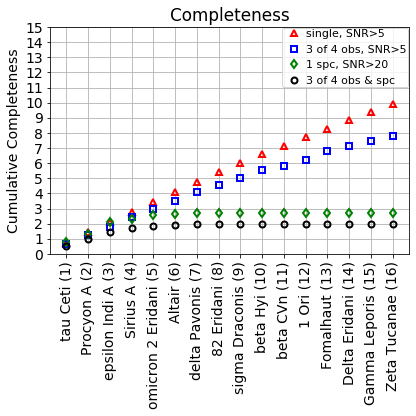

In [8]:
figure(figsize=(6,6))
plot(cumsum(svs_C_list_cut[idx]), 'r^', mfc='none', mew=2, label='single, SNR>5')
plot(cumsum(orb_C_list_cut[idx]), 'bs', mfc='none', mew=2, label='3 of 4 obs, SNR>5')
plot(cumsum(spc_C_list_cut[idx]), 'gd', mfc='none', mew=2, label='1 spc, SNR>20')
plot(cumsum(bth_C_list_cut[idx]), 'ko', mfc='none', mew=2, label='3 of 4 obs & spc')
ylim(0.,15.)
xticks(range(0, len(orb_C_list_cut)), name_array, rotation=90)
yticks(range(0,16))
#plot(5.*np.ones(len(orb_C_list_cut)), 'r--')
ylabel('Cumulative Completeness')
title('Completeness')
grid('True')
legend(loc=0, borderaxespad=0.1, borderpad=0.1, handletextpad=0.1, fontsize=11)
tight_layout()
savefig('cumulative_completeness.pdf')

star_8102_imgspc.npz 0.72438 tau Ceti (1)
star_37279_imgspc.npz 0.72285 Procyon A (2)
star_108870_imgspc.npz 0.68672 epsilon Indi A (3)
star_32349_imgspc.npz 0.66143 Sirius A (4)
star_19849_imgspc.npz 0.66782 omicron 2 Eridani (5)
star_97649_imgspc.npz 0.60342 Altair (6)
star_99240_imgspc.npz 0.66444 delta Pavonis (7)
star_15510_imgspc.npz 0.66114 82 Eridani (8)
star_96100_imgspc.npz 0.59421 sigma Draconis (9)
star_2021_imgspc.npz 0.60309 beta Hyi (10)
star_61317_imgspc.npz 0.52562 beta CVn (11)
star_22449_imgspc.npz 0.59506 1 Ori (12)
star_113368_imgspc.npz 0.56831 Fomalhaut (13)
star_17378_imgspc.npz 0.55696 Delta Eridani (14)
star_27072_imgspc.npz 0.54158 Gamma Leporis (15)
star_1599_imgspc.npz 0.51325 Zeta Tucanae (16)
<a list of 11 Text xticklabel objects>


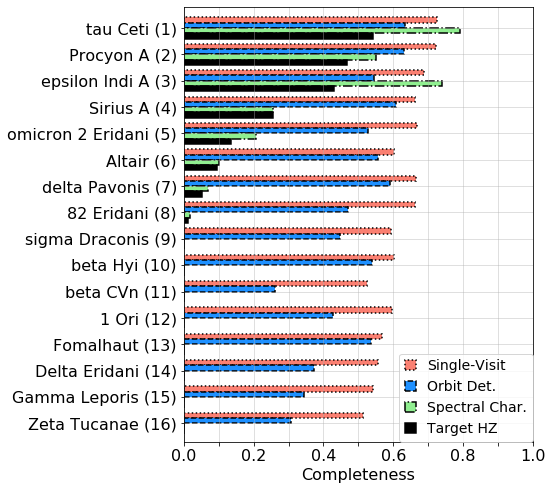

In [9]:
# create plot
rcParams['font.size']=16
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

n_groups = len(svs_C_list_cut[idx])


figure(figsize=(8.5,8))
ax = subplot(111)
index = np.arange(n_groups)[::-1]
bar_width = 0.2
opacity = 0.8

cc=-1
for ii in idx:
    cc+=1
    print(fnm_list[ii], svs_C_list_cut[ii], name_array[cc])
rects1 = plt.barh(index + 2.5*bar_width, svs_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 ls =':',
                 color='salmon',
                 edgecolor='k',
                 lw=1.5,
                 label='Single-Visit')

rects2 = plt.barh(index + 1.5*bar_width, orb_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 lw=1.5,
                 ls = '--',
                 edgecolor='k',
                 color='dodgerblue',
                 #hatch = '///', 
                 label='Orbit Det.',)

rects3 = plt.barh(index + 0.5*bar_width, spc_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 lw=1.5,
                 ls = '-.',
                 edgecolor='k',
                 color='lightgreen',
                 #hatch = '\\', 
                 label='Spectral Char.')

rects4 = plt.barh(index - 0.5*bar_width, bth_C_list_cut[idx], bar_width,
                 alpha=1.0,
                 color='k',
                 edgecolor='k',
                 lw=1.5,
                 label='Target HZ')

yticks(index+bar_width, name_array, rotation=0)
xlabel('Completeness')
#title('Completeness')
ylim(-0.5, 16.)
xticks(np.arange(0.,1.05, 0.1))
plt.legend(loc=4, fontsize=14, borderaxespad=0.0, handlelength=0.8)
grid(True, which='both', alpha=0.5)

print(ax.get_xticklabels())
for label in ax.get_xticklabels()[1::2]:
    label.set_visible(False)

xlim(0., 1.)
subplots_adjust(left=0.33)
savefig('Completeness_by_target.pdf')